In [176]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import os
from geopy.distance import geodesic


convertTime = lambda x : datetime.strptime(x, "%Y/%m/%d - %H:%M:%S").strftime("%Y-%m-%dT%H:%M:%SZ")

In [177]:
def traitement(nomcsv, nomtel, nomresult):
    try:
        # Chargement des données
        acquisitionGPS = pd.read_csv(f'results/acquisitionsGPS/{nomcsv}.csv')
        acquisitionTEL = pd.read_csv(f'results/acquisitionsTELEPHONE/CSV/{nomtel}.csv')
    except FileNotFoundError as e:
        print(f"Erreur : fichier non trouvé - {e}")
        return
    except pd.errors.EmptyDataError:
        print("Erreur : un des fichiers CSV est vide.")
        return
    except pd.errors.ParserError:
        print("Erreur : problème de format dans un fichier CSV.")
        return

    # Conversion du temps et tri des données
    acquisitionGPS['UTC'] = pd.to_datetime(acquisitionGPS['UTC'].apply(convertTime), errors='coerce')
    acquisitionTEL['UTC'] = pd.to_datetime(acquisitionTEL['UTC'], errors='coerce')

    # Fusion asynchrone sur UTC
    merged_df = pd.merge_asof(
        acquisitionGPS.sort_values('UTC'),
        acquisitionTEL.sort_values('UTC'),
        on='UTC', suffixes=('_1', '_2')
    ).dropna()

    # Fonction de calcul de la distance Haversine
    def haversine_distance(lat1, lon1, lat2, lon2):
        return geodesic((lat1, lon1), (lat2, lon2)).meters

    # Calcul de la distance entre points GPS et Téléphone
    merged_df['distance'] = merged_df.apply(lambda row: haversine_distance(
        row['Latitude_1'], row['Longitude_1'], row['Latitude_2'], row['Longitude_2']
    ), axis=1)

    # Affichage des statistiques d'erreur
    print(f"Erreur moyenne : {merged_df['distance'].mean():.2f} mètres")
    print(f"Erreur max : {merged_df['distance'].max():.2f} mètres")
    print(f"Erreur min : {merged_df['distance'].min():.2f} mètres")

    # Calcul des coordonnées moyennes
    merged_df['Latitude_corrigée'] = merged_df[['Latitude_1', 'Latitude_2']].mean(axis=1)
    merged_df['Longitude_corrigée'] = merged_df[['Longitude_1', 'Longitude_2']].mean(axis=1)

    # Création du dossier de sauvegarde
    output_folder = f'traitements/{nomresult}'
    os.makedirs(output_folder, exist_ok=True)

    # Graphiques comparatifs
    plt.figure(figsize=(8, 6))
    plt.scatter(merged_df['Longitude_1'], merged_df['Latitude_1'], label='GPS', alpha=0.6)
    plt.scatter(merged_df['Longitude_2'], merged_df['Latitude_2'], label='Tel', alpha=0.6, marker='x')
    plt.scatter(merged_df['Longitude_corrigée'], merged_df['Latitude_corrigée'], label='Trajet Moyen', alpha=0.6, marker='x')
    plt.legend()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Comparaison des trajets GPS')
    plt.savefig(f'{output_folder}/comparaison_trajets.png')
    plt.show()

    # Courbe des erreurs
    plt.figure()
    plt.plot(merged_df['distance'], label='Distance GPS - Tel')
    plt.xlabel('Index')
    plt.ylabel('Distance (mètres)')
    plt.title("Évolution de l'erreur")
    plt.legend()
    plt.savefig(f'{output_folder}/erreur_evolution.png')
    plt.show()

    # Comparaison Latitude et Longitude
    plt.figure()
    plt.plot(merged_df['Latitude_1'], label='Latitude GPS')
    plt.plot(merged_df['Latitude_2'], label='Latitude Tel')
    plt.legend()
    plt.savefig(f'{output_folder}/comparaison_latitude.png')
    plt.show()

    plt.figure()
    plt.plot(merged_df['Longitude_1'], label='Longitude GPS')
    plt.plot(merged_df['Longitude_2'], label='Longitude Tel')
    plt.legend()
    plt.savefig(f'{output_folder}/comparaison_longitude.png')
    plt.show()

    # Sauvegarde des résultats
    output_file = f'{output_folder}/results.csv'
    merged_df.to_csv(output_file, index=False)
    print(f"Résultats sauvegardés dans : {output_file}")

Erreur moyenne : 19.51 mètres
Erreur max : 68.54 mètres
Erreur min : 0.43 mètres


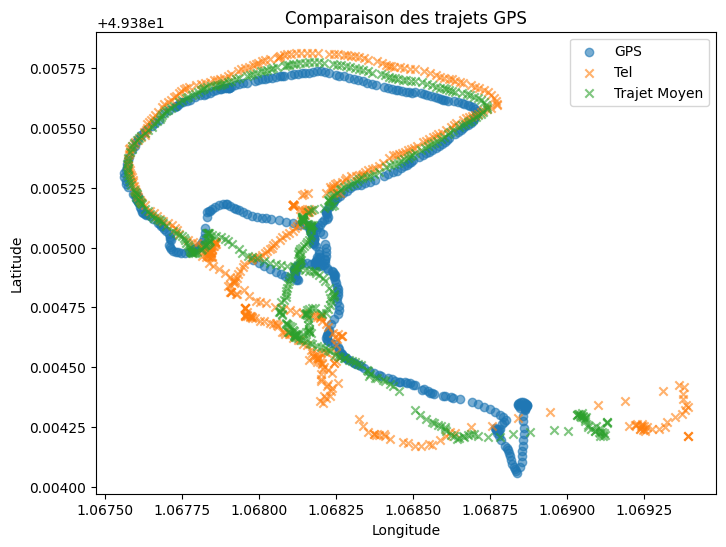

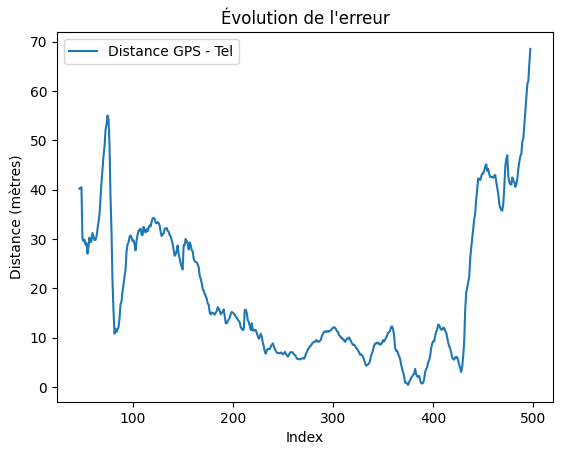

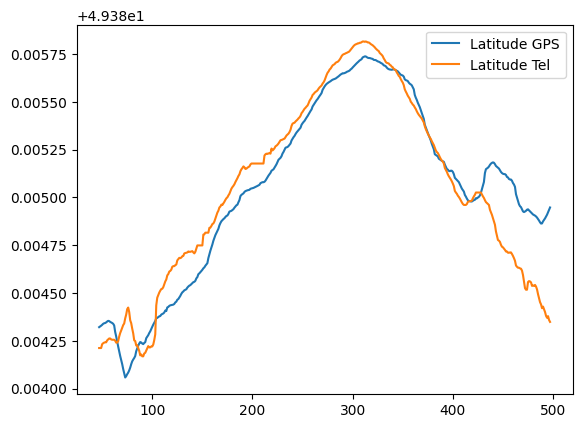

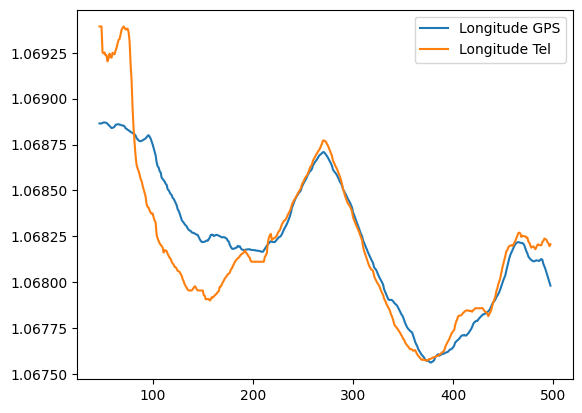

Résultats sauvegardés dans : traitements/gps1/results.csv


In [178]:
traitement("gps1","acquisition1","gps1")